In [1]:
import shutil

import dask
import dask.array
import dask.dataframe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wisc_ecephys_tools as wet
import xarray as xr
from dask.distributed import Client
from ecephys import xrsig
from ecephys.utils import dask_utils

from findlay2025a import core, dentate_spikes
from findlay2025a.constants import Experiments, Files

In [ ]:
client = Client()
print(client.dashboard_link)

In [6]:
sglx_subject = wet.get_sglx_subject("CNPIX14-Francis")
experiment = Experiments.NOD

In [7]:
s3 = core.get_project("shared")
nb = core.get_project("seahorse")

opts = s3.load_experiment_subject_params(experiment, sglx_subject.name)
hg = s3.load_float_hypnogram(experiment, sglx_subject.name, simplify=True)
lfp = core.open_hippocampal_lfps(sglx_subject.name, experiment)
kcsd = (
    core.open_kcsd(sglx_subject.name, experiment)
    .assign_attrs(fs=lfp.fs)
    .assign_coords(acronym=lfp.acronym)
)
fs = lfp.fs

region_bounds = dentate_spikes.get_region_bounds(kcsd)

chans = kcsd.channel.values
y = kcsd.y.values

dorsal_sink_chans = chans[
    (y >= opts["dorsal_dentate_sink_lo"]) & (y <= opts["dorsal_dentate_sink_hi"])
]
dorsal_source_chans = chans[
    (y >= opts["dorsal_dentate_source_lo"]) & (y <= opts["dorsal_dentate_source_hi"])
]
do_ventral = "ventral_dentate_sink_lo" in opts
if do_ventral:
    ventral_sink_chans = chans[
        (y >= opts["ventral_dentate_sink_lo"]) & (y <= opts["ventral_dentate_sink_hi"])
    ]
    ventral_source_chans = chans[
        (y >= opts["ventral_dentate_source_lo"])
        & (y <= opts["ventral_dentate_source_hi"])
    ]
else:
    ventral_sink_chans = None
    ventral_source_chans = None

/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:142: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 128069. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)
/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:142: UserWarning: The specified chunks separate the stored chunks along dimension "channel" starting at index 262. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)


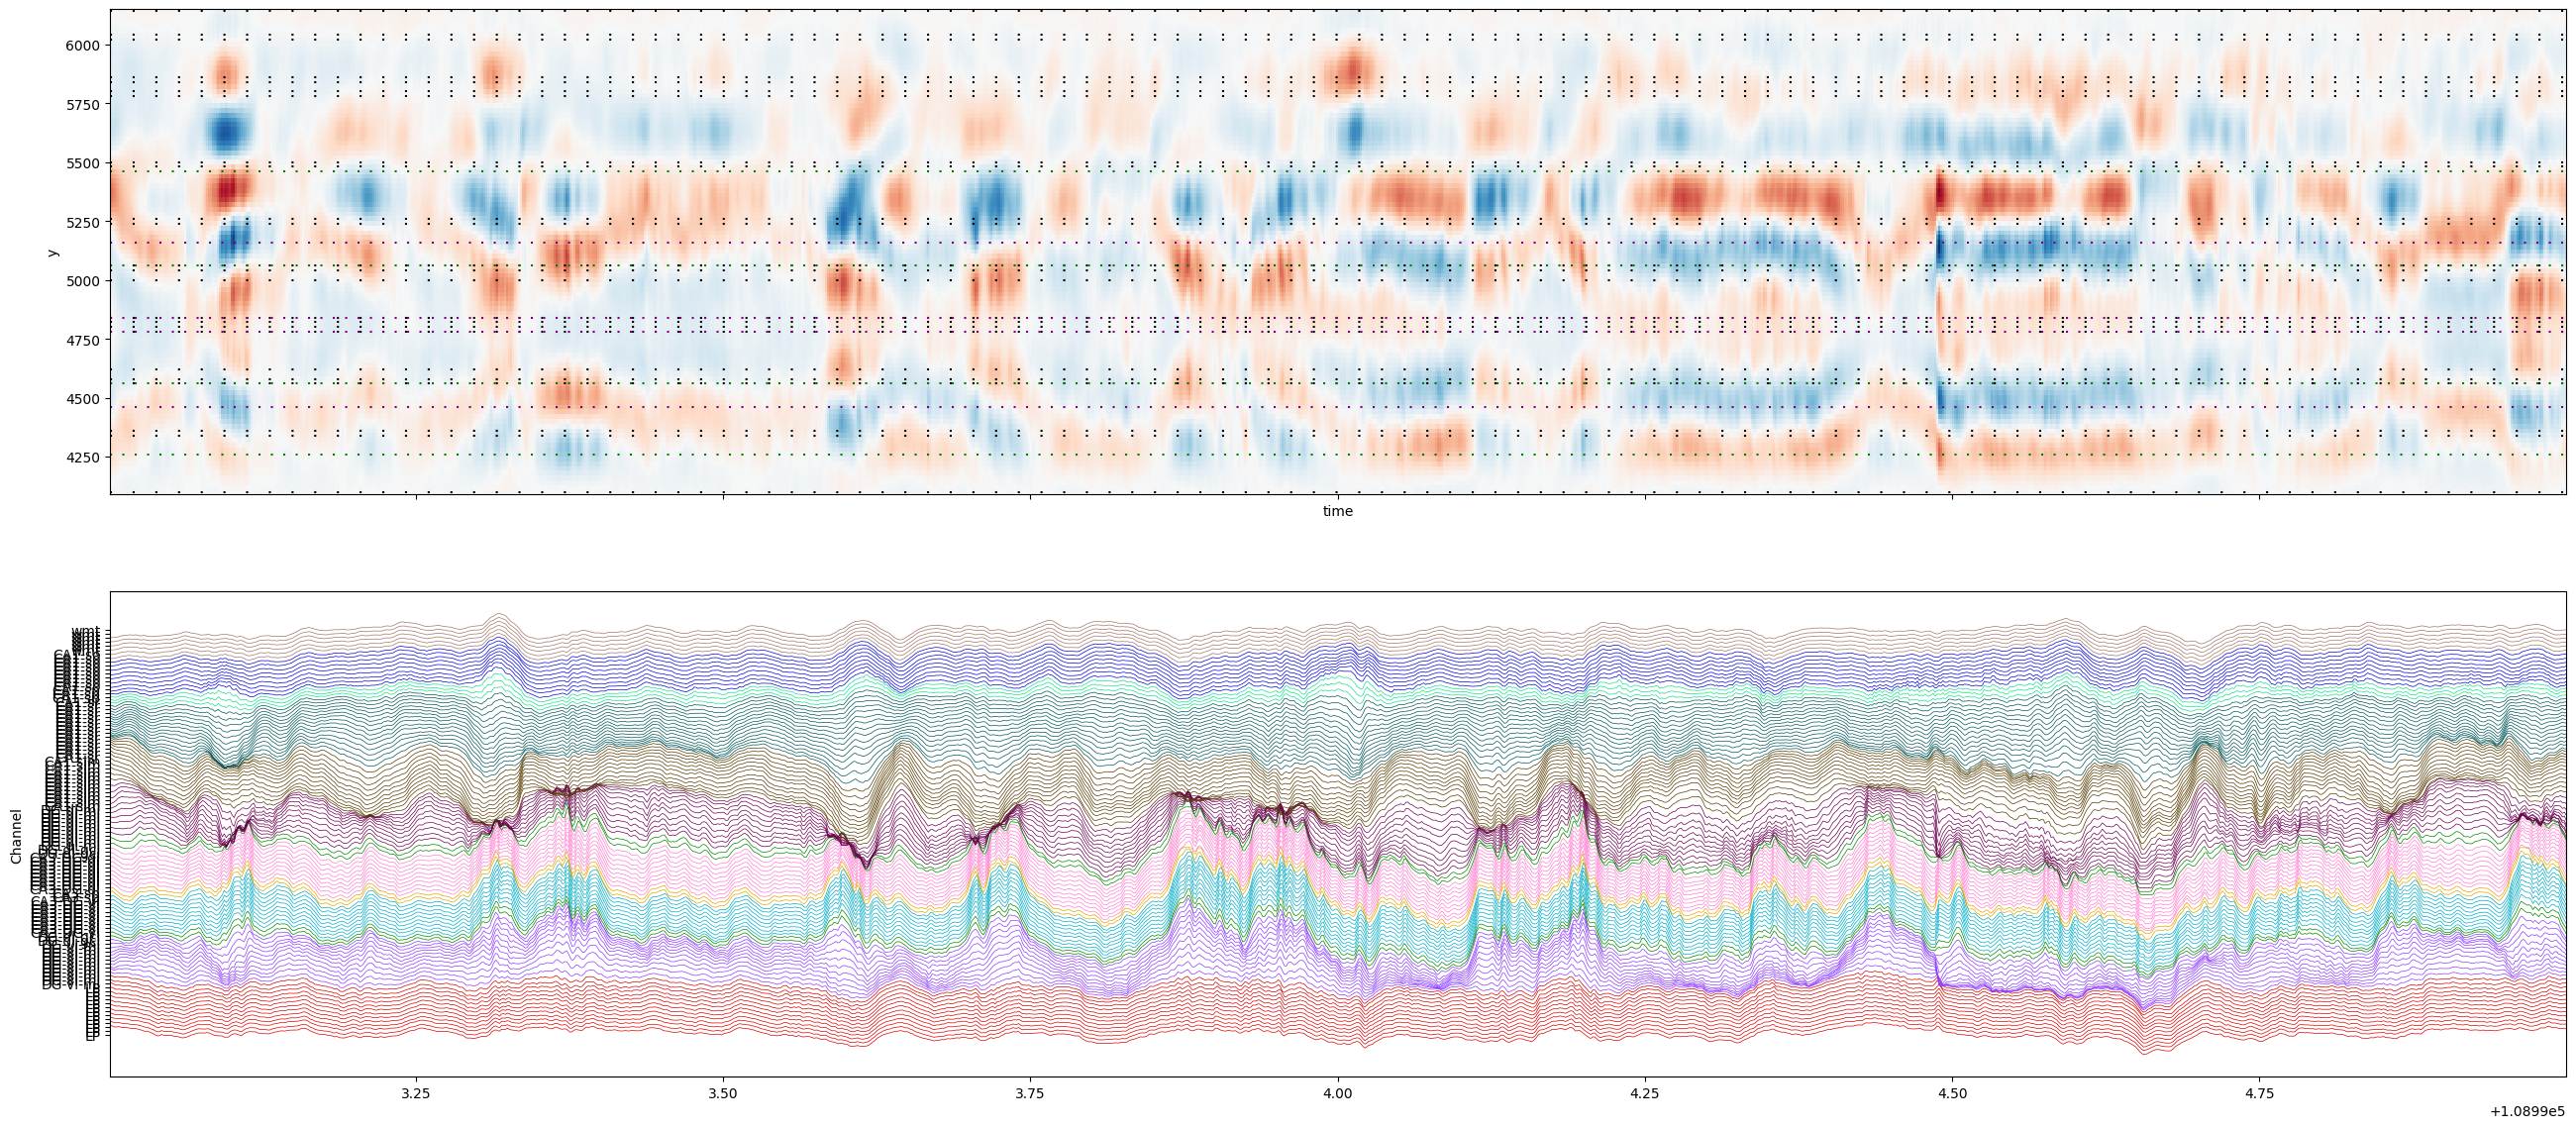

In [10]:
# Optional: Visualize detection zones
RUN = True
if RUN:
    estm_start, estm_end = core.get_estimation_bounds(sglx_subject, experiment)
    offset = 999
    duration = 2

    dentate_spikes.visualize_detection_zones(
        estm_start + offset,
        estm_start + offset + duration,
        kcsd,
        lfp,
        region_bounds,
        dorsal_sink_chans,
        dorsal_source_chans,
        ventral_sink_chans,
        ventral_source_chans,
    )

# Estimate detection parameters for dentate spikes

In [11]:
estm_start, estm_end = core.get_estimation_bounds(sglx_subject, experiment)
artifacts = core.load_artifacts(experiment, sglx_subject.name)
estm_lfp = core.drop_artifacts(lfp.sel(time=slice(estm_start, estm_end)), artifacts, hg)
estm_kcsd = core.drop_artifacts(
    kcsd.sel(time=slice(estm_start, estm_end)), artifacts, hg
)

estm_kcsd_filt = xrsig.butter_bandpass(
    estm_kcsd,
    lowcut=dentate_spikes.DETECTION_LOWCUT,
    highcut=dentate_spikes.DETECTION_HIGHCUT,
    order=dentate_spikes.DETECTION_FILTER_ORDER,
    plot=False,
).compute()

(
    estm_dorsal_sink_series,
    estm_dorsal_source_series,
    estm_dorsal_detection_series,
) = dentate_spikes.get_leaf_detection_series(
    estm_kcsd_filt.sel(channel=dorsal_sink_chans),
    estm_kcsd_filt.sel(channel=dorsal_source_chans),
)
if ventral_sink_chans is not None:
    (
        estm_ventral_sink_series,
        estm_ventral_source_series,
        estm_ventral_detection_series,
    ) = dentate_spikes.get_leaf_detection_series(
        estm_kcsd_filt.sel(channel=ventral_sink_chans),
        estm_kcsd_filt.sel(channel=ventral_source_chans),
    )
    estm_detection_series = estm_dorsal_detection_series + estm_ventral_detection_series
else:
    estm_ventral_sink_series = estm_ventral_source_series = (
        estm_ventral_detection_series
    ) = None
    estm_detection_series = estm_dorsal_detection_series

estm_pks = dentate_spikes.detect_peaks(
    estm_detection_series,
    estm_kcsd_filt.fs,
    estm_dorsal_sink_series,
    estm_dorsal_source_series,
    estm_ventral_sink_series,
    estm_ventral_source_series,
)

estm_dspks = dentate_spikes.extract_dentate_spikes(estm_pks)

peak_frame                              3177205
peak_time                         113077.529322
peak_height                       148593.297602
dvorak_prominence                  114844.88102
dvorak_width                             0.0128
jones_prominence                   114844.88102
jones_width                              0.0128
findlay_prominence                 92037.758197
scipy_prominence                  143189.502254
scipy_width                              0.4512
dorsal_sink_channel                         137
dorsal_sink_y                            5200.0
dorsal_sink_structure                  DG-dl-ml
dorsal_source_channel                       113
dorsal_source_y                          4960.0
ventral_sink_channel                         57
ventral_sink_y                           4400.0
ventral_sink_structure                 DG-vl-ml
ventral_source_channel                       81
ventral_source_y                         4640.0
dorsal_sink_source_separation           

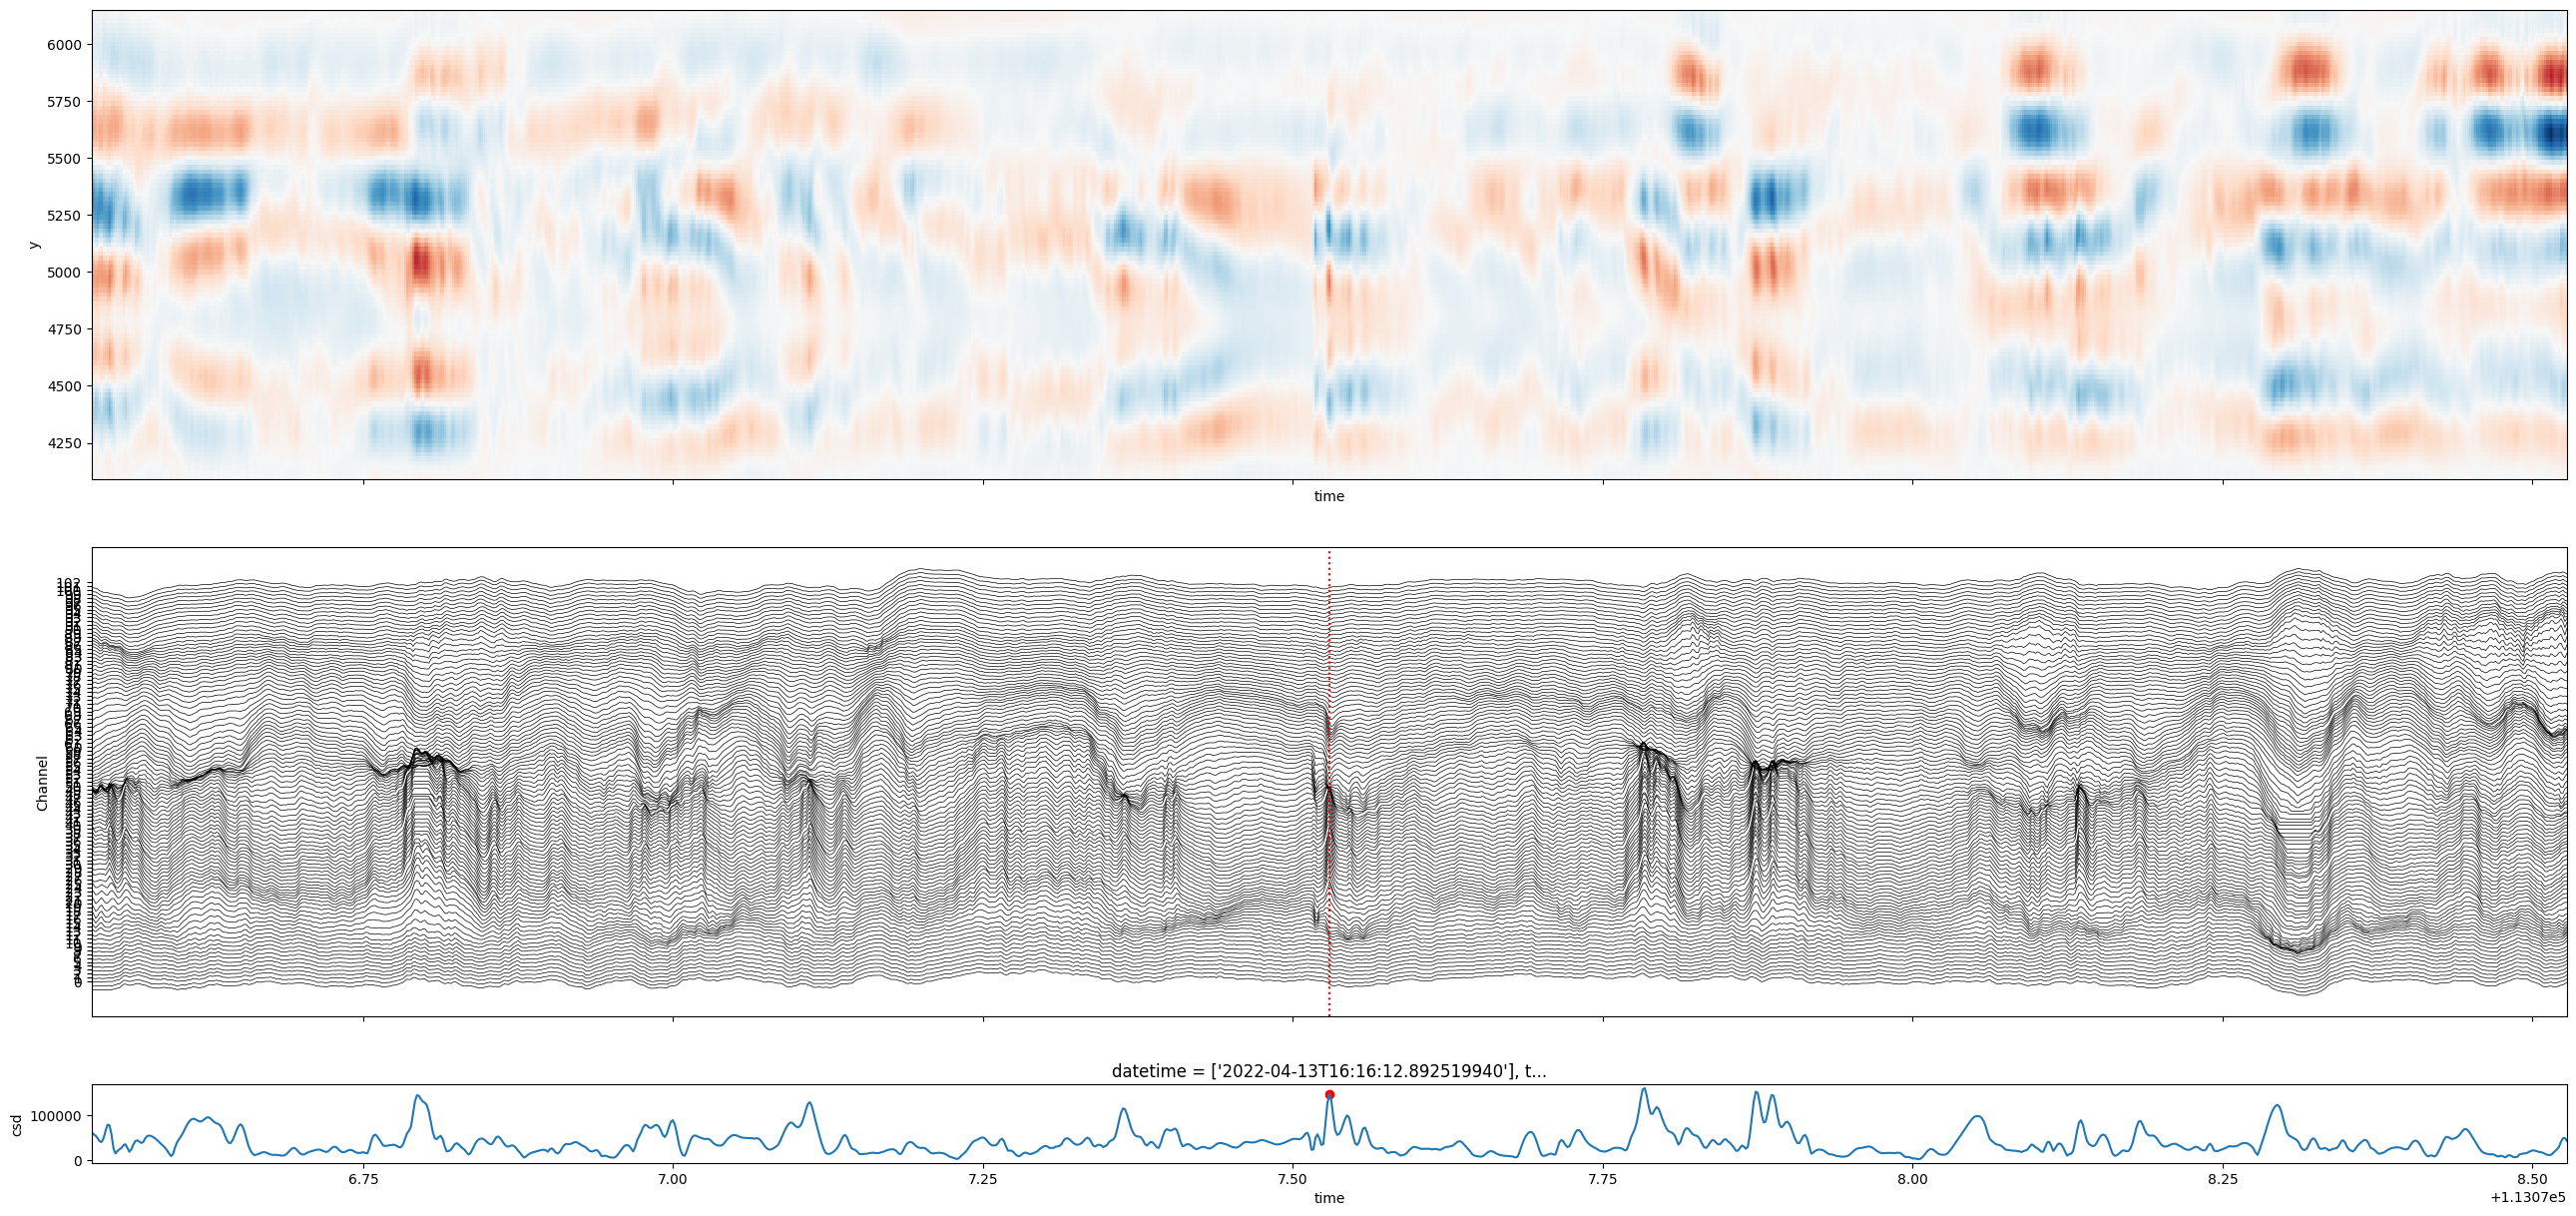

In [15]:
dentate_spikes.examine_event(estm_dspks, estm_lfp, estm_kcsd, estm_detection_series)

In [16]:
estm_dspks_file = nb.get_experiment_subject_file(
    experiment, sglx_subject.name, Files.ESTM_DSPKS
)
estm_dspks.to_parquet(estm_dspks_file)

dspk_detection_params = dict(
    lowcut=dentate_spikes.DETECTION_LOWCUT,
    highcut=dentate_spikes.DETECTION_HIGHCUT,
    order=dentate_spikes.DETECTION_FILTER_ORDER,
    dorsal_sink_chans=dorsal_sink_chans,
    dorsal_source_chans=dorsal_source_chans,
)
if ventral_sink_chans is not None:
    dspk_detection_params.update(
        ventral_sink_chans=ventral_sink_chans, ventral_source_chans=ventral_source_chans
    )
dspk_params_file = nb.get_experiment_subject_file(
    experiment, sglx_subject.name, Files.DSPK_PARAMS
)
np.savez(dspk_params_file, **dspk_detection_params)

# Get ERP AND ERC for estimation period dentate spikes

In [17]:
estm_lfp = estm_lfp.compute()
estm_dspk_lfps, in_estm_lfps = xrsig.make_trialed(
    estm_lfp, pre=0.5, post=0.5, event_frames=estm_dspks.peak_frame.values
)
if not in_estm_lfps.all():
    print("Warning: Not all events are in bounds")
estm_dspk_lfps = xrsig.detrend_trialed(estm_dspk_lfps)
estm_dspk_erps = estm_dspk_lfps.mean(dim="event").assign_attrs(fs=estm_lfp.fs)

estm_kcsd = estm_kcsd.compute()
estm_dspk_csds, in_estm_csds = xrsig.make_trialed(
    estm_kcsd, pre=0.5, post=0.5, event_frames=estm_dspks.peak_frame.values
)
if not in_estm_csds.all():
    print("Warning: Not all events are in bounds")
estm_dspk_ercs = estm_dspk_csds.mean(dim="event").assign_attrs(fs=estm_kcsd.fs)

Fitting detrend polynomial...
Evaluating detrend polynomial...
Subtracting detrend polynomial...


(-0.15, 0.15)

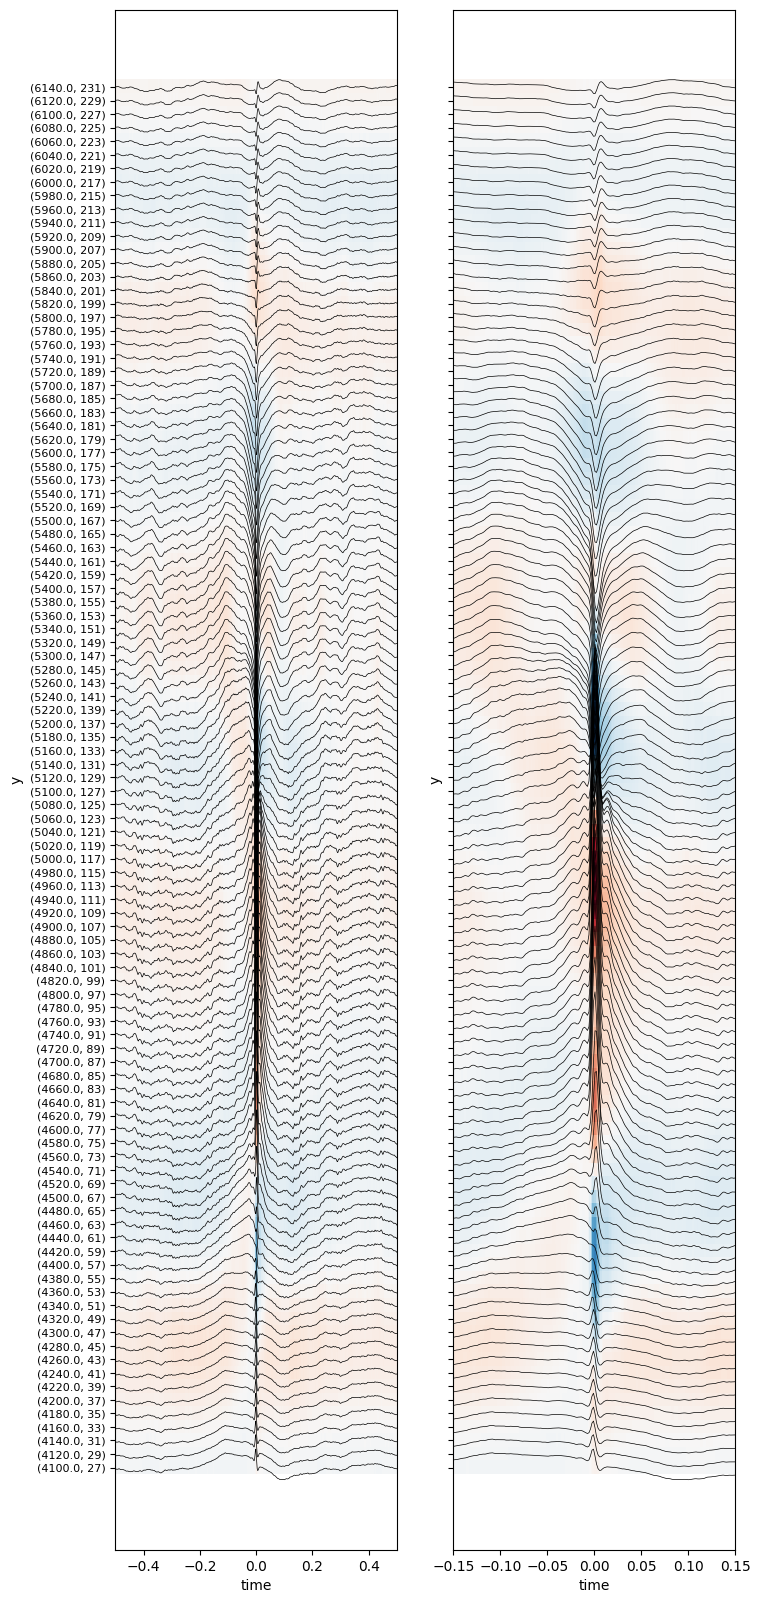

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(8, 20), sharey=True)
xrsig.plot_laminar_image_vertical(estm_dspk_ercs, x="time", ax=axes[0])
xrsig.plot_laminar_timeseries(estm_dspk_erps, gain=0.25, ax=axes[0])
xrsig.plot_laminar_image_vertical(estm_dspk_ercs, x="time", ax=axes[1])
xrsig.plot_laminar_timeseries(estm_dspk_erps, gain=0.25, ax=axes[1])
axes[1].set_xlim(-0.15, 0.15)

# Detect whole-experiment dentate spikes

In [19]:
shifts = core.read_shifts(sglx_subject.name, experiment)
kcsd_filt = xrsig.butter_bandpass(
    kcsd,
    lowcut=dspk_detection_params["lowcut"],
    highcut=dspk_detection_params["highcut"],
    order=dspk_detection_params["order"],
    plot=False,
)
kcsd_filt = dentate_spikes.shift_blocks(kcsd_filt, shifts)

In [19]:
# Define computation
result_dtypes = estm_dspks.dtypes.to_dict()


@dask.delayed
def detect_block_peaks(kcsd_filt: xr.DataArray, first_frame: int) -> pd.DataFrame:
    (
        dorsal_sink_series,
        dorsal_source_series,
        dorsal_detection_series,
    ) = dentate_spikes.get_leaf_detection_series(
        kcsd_filt.sel(channel=dspk_detection_params["dorsal_sink_chans"]),
        kcsd_filt.sel(channel=dspk_detection_params["dorsal_source_chans"]),
    )
    if "ventral_sink_chans" in dspk_detection_params:
        (
            ventral_sink_series,
            ventral_source_series,
            ventral_detection_series,
        ) = dentate_spikes.get_leaf_detection_series(
            kcsd_filt.sel(channel=dspk_detection_params["ventral_sink_chans"]),
            kcsd_filt.sel(channel=dspk_detection_params["ventral_source_chans"]),
        )
        detection_series = dorsal_detection_series + ventral_detection_series
    else:
        ventral_sink_series = ventral_source_series = ventral_detection_series = None
        detection_series = dorsal_detection_series
    df = dentate_spikes.detect_peaks(
        detection_series,
        kcsd_filt.fs,
        dorsal_sink_series,
        dorsal_source_series,
        ventral_sink_series,
        ventral_source_series,
    )
    df["peak_frame"] += first_frame
    return df.astype(result_dtypes)


meta = dask.dataframe.utils.make_meta(result_dtypes)
chunk_bounds = dask_utils.get_dask_chunk_bounds(
    kcsd_filt.data, axis=kcsd_filt.get_axis_num("time")
)
n_chunks = len(chunk_bounds) - 1
results = [
    dask.dataframe.from_delayed(
        detect_block_peaks(
            kcsd_filt.isel(time=slice(chunk_bounds[i], chunk_bounds[i + 1])),
            chunk_bounds[i],
        ),
        meta=meta,
    )
    for i in range(n_chunks)
]
ddf = dask.dataframe.concat(results)
# Compute and write to disk
tmp_dpk_file = nb.get_experiment_subject_file(
    experiment, sglx_subject.name, Files.TMP_DPKS
)
ddf.to_parquet(tmp_dpk_file, compute=True)

In [ ]:
ddf = pd.read_parquet(tmp_dpk_file).reset_index(drop=True)
ddf = dentate_spikes.add_zlog_prominence(ddf)
dpk_file = nb.get_experiment_subject_file(experiment, sglx_subject.name, Files.DPKS)
ddf.to_parquet(dpk_file)
shutil.rmtree(tmp_dpk_file)

dspks = dentate_spikes.extract_dentate_spikes(ddf, estm_dspks)
dspk_file = nb.get_experiment_subject_file(experiment, sglx_subject.name, Files.DSPKS)
dspks.to_parquet(dspk_file)